<a href="https://colab.research.google.com/github/jvictorferreira3301/LPTP_Analyzer/blob/main/LPTP_Analyzer.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 27px; margin-right: 10px;"/>

# Análise Estatística da Sincronização de Tempo em Redes Locais Usando LinuxPTP



A sincronização precisa de tempo em redes de computadores é fundamental para diversas aplicações, incluindo redes industriais, telecomunicações e data centers. Neste trabalho, utilizamos o [LinuxPTP](https://linuxptp.sourceforge.net/), uma implementação do [Precision Time Protocol (PTP)](https://endruntechnologies.com/pdf/PTP-1588.pdf), para simular e analisar a sincronização de tempo entre diferentes nós de uma rede. O LinuxPTP oferece uma maneira robusta de sincronizar relógios em diferentes dispositivos numa LAN, permitindo atingir precisões na ordem de microssegundos ou até nanosegundos, dependendo das condições da rede e do hardware disponível.

A análise deste trabalho é feita utilizando **Estatística Descritiva e Inferencial**, com a aplicação de **testes de hipóteses** para avaliar o comportamento da sincronização em diferentes cenários. Para isso, configuramos nós em uma rede local que atuam como mestres e escravos PTP, e coletamos dados de _**Time offset**_ durante a sincronização.

Os principais objetivos deste trabalho incluem:

- **$I.$ Testar _Timestamping_ em _Software_ vs. _Hardware_**: Comparar a eficácia da sincronização utilizando **timestamping em software** e **timestamping em hardware**.

- **$II.$ Comparar Topologias de Sincronização**: Verificar a eficácia de diferentes configurações, como topologias **mestre-escravo** simples e aquelas que envolvem **_Transparent Clocks_** ou **_Boundary Clocks_**.


## Ambiente de testes



Para este estudo, utilizamos 3 computadores cuja as especificações são descritas na tabela abaixo:

| Especificação      | PC 1 (jv3301)                | PC 2 (Vostro-3470)               | PC 3 (lasse100)                      |
|--------------------|---------------------------------|--------------------------------------------|-----------------------------------------|
| OS                 | Ubuntu 22.04.5 LTS        | Ubuntu 22.04.4 LTS                   | Ubuntu 18.04.4 LTS                |
| Kernel             | 6.8.0-45-generic                | 6.5.0-35-generic                           | 4.15.0-213-generic                      |
| NIC                 | Intel X550-T2 PCI-E X4         | Intel X550-T2 PCI-E X4                     | Intel X550-T2 PCI-E X4      |
| CPU                | Intel i5-7600 (4) 4.1GHz     | Intel i5-9400 (6) 4.1GHz                | Intel i7-5930K (12) 3.7GHz          |
| GPU                | Intel HD Graphics 630           | Intel HD Graphics 630  | AMD Radeon HD 7770/8760                 |
| Memory             | 8GB                 | 16GB                           | 64GB                        |

**Tabela 1** - Especificações dos computadores utilizados nos testes.

## Precision Time Protocol (PTP)


<div style="display: flex; align-items: center;">
    <div style="margin-right: 20px;">
        <p>O Precision Time Protocol (PTP) é um protocolo de rede utilizado para sincronizar relógios em sistemas de computadores distribuídos. Ele é definido pelo padrão IEEE 1588 e é amplamente utilizado em aplicações que requerem alta precisão na sincronização de tempo, como redes de telecomunicações, sistemas de automação industrial e data centers.</p>
        <h4> Mestre e Escravo:</h4>
   <p>- O PTP opera em uma arquitetura mestre-escravo, onde um dispositivo mestre (Master) distribui o tempo para um ou mais dispositivos escravos (Slaves).
   <p>- O mestre é responsável por enviar mensagens de sincronização para os escravos.</p>
        <h4> Mensagens de Sincronização:</h4>
   <p>- Sync: O mestre envia uma mensagem de sincronização (Sync) contendo a hora atual.
   <p>- Follow_Up: Opcionalmente, o mestre pode enviar uma mensagem de acompanhamento (Follow_Up) com informações adicionais de tempo.
   <p>- Delay_Request: O escravo envia uma mensagem de solicitação de atraso (Delay_Request) para o mestre.
   <p>- Delay_Response: O mestre responde com uma mensagem de resposta de atraso (Delay_Response) contendo o tempo de recepção da solicitação.
    </div>
    <figure style="text-align: center;">
        <img src="./assets/PTP.png" width="auto" height="auto">
        <figcaption>Fig. 1 - Diagrama lúdico do PTP.</figcaption>
    </figure>
</div>

## Linux PTP


O [LinuxPTP](https://linuxptp.sourceforge.net/) é uma implementação do Precision Time Protocol (PTP), conforme definido pelo padrão [**IEEE 1588**](https://endruntechnologies.com/pdf/PTP-1588.pdf). O LinuxPTP é utilizado para sincronizar relógios de uma rede local (LAN) em terminais linux.

Componentes Principais:

- `ptp4l`: O daemon principal do LinuxPTP, responsável por implementar o protocolo PTP e gerenciar a sincronização de tempo entre os dispositivos.
- `phc2sys`: Uma ferramenta auxiliar que sincroniza o relógio de hardware do PTP (PHC) com o relógio do sistema, garantindo que ambos permaneçam alinhados.

<div style="display: flex; justify-content: center;">
    <figure style="margin-right: 10px; text-align: center;">
        <img src="./assets/log.png" width="auto" height="auto" style="display: flex; margin:0">
        <figcaption>Fig. 2 - Exemplo de log do linux PTP. </figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="./assets/HS.png" width="auto" height="auto" tyle="display: flex; margin:10px">
        <figcaption> Fig. 3 - Diagrama do LinuxPTP.</figcaption>
    </figure>
</div>

## $I$. Software Timestamping Vs. Hardware Timestamping


Para a primeira análise inferencial vamos comparar o sincronismo utilizando **Software Timestamping** Vs. **Hardware Timestamping**. 

<!-- - **Software timestamping** é o processo de marcar o tempo de eventos diretamente no software. Isso geralmente é feito no nível da aplicação ou do sistema operacional. A precisão do timestamp depende da carga do sistema e da latência do software, o que pode introduzir variações e atrasos.

- **Hardware timestamping**, por outro lado, envolve a marcação de tempo diretamente no hardware de rede, como em placas de rede (NICs). Isso permite uma precisão muito maior, pois os timestamps são gerados no momento exato em que os pacotes são enviados ou recebidos, minimizando a latência e a variação introduzida pelo software. -->

<!-- Nas imagens abaixo podemos ver onde cada tipo de timestamping atua na camada de pilhas e a topologia usada para essa primeira comparação: -->

| Característica         | Software Timestamp                  | Hardware Timestamp                  |
|------------------------|-------------------------------------|-------------------------------------|
| **Precisão**           | Menos preciso                       | Muito preciso                       |
| **Latência**           | Alta (introduzida pelo SO e driver) | Baixa (registrada diretamente pelo hardware) |
| **Jitter**             | Alto                                | Baixo                               |
| **Custo**              | Baixo                               | Alto                                |
| **Complexidade**       | Baixa                               | Alta                                |
| **Uso Comum**          | Aplicações não críticas             | Aplicações críticas                 |


Nas imagens abaixo podemos ver onde cada tipo de timestamping atua na camada de pilhas e a topologia usada para essa primeira comparação:

<div style="display: flex; justify-content: center;">
    <figure style="margin-right: 10px; text-align: center;">
        <img src="./assets/ptp-hardware-software-based-timestamp.png" width="500" height="480" style="display: flex; margin:0">
        <figcaption>Fig. 4 - Hardware Vs. Software Timestamping. <a href="https://networklessons.com/cisco/ccnp-encor-350-401/introduction-to-precision-time-protocol-ptp#:~:text=PTP%20works%20best%20when%20your%20hardware%20supports%20it.%20A%20NIC%20with%20PTP%20support%20has%20its%20own%20onboard%20clock%2C%20which%20is%20used%20to%20timestamp%20messages.%20You%20can%20run%20PTP%20in%20software%20without%20hardware%20support%2C%20but%20your%20OS%20will%20have%20to%20take%20care%20of%20timestamping.%20This%20negatively%20affects%20delay.">Fonte</a></figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="./assets/topo1.png" width="500" height="480" tyle="display: flex; margin:10px">
        <figcaption>Fig. 5 -Topologia do teste 1.</figcaption>
    </figure>
</div>

A segunda imagem ilustra uma topologia de rede ponto a ponto, composta por dois computadores: PC 3 (nó "_Master_") e PC 1 (nó "_Slave_"). Esses dispositivos estão conectados diretamente por um link físico, representado pela linha azul, sem outros dispositivos de rede intermediários. Ambos os PCs possuem placas de interface de rede Intel X550-T2 PCI-E X4, que são usadas para estabelecer a comunicação direta.

Para realizar os testes de sincronização de tempo, configuramos o PC 3 como o mestre executando o comando `ptp4l`, enquanto o PC 1 foi definido como escravo também utilizando `ptp4l`. No lado do _slave_, o log da execução foi redirecionado para um arquivo de texto, registrando dados por um período de 30 minutos. Fizemos esses mesmos passos testando ambas as formas de timestamping.

Abaixo, realizamos o carregamento e processamento dos logs de PTP para extrair informações de time offset e frequency offset, a fim de armazenar esses dados em DataFrames para posterior análise e visualização.

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot, levene
from src.log_processing import process_log_file
from src.plotting import plot_graphs, plot_acf_log, plot_frequency_graphs


# Padroes de time e freq
offset_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)'
freq_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)'

log_files1 = ['logs/Soft.txt', 'logs/Hard.txt'] # Arquivos de texto contendo o log extraido do ptp4l.

# Soft.txt -> log da sincronização usando software timestamping.
# Hard.txt -> log da sincronização usando hardware timestamping.

dataframes1 = {}

for log_file in log_files1:
    df = process_log_file(log_file, offset_pattern, freq_pattern)
    df = df.drop(columns=['frequency_offset'])
    dataframes1[log_file] = df

Dados a leitura e o processamento, agora podemos visualizar os dados de Software e Hardware timestamping 

### 1.1 - Dados do sincronismo usando software timestamping



In [184]:
df_s_log = dataframes1['logs/Soft.txt']# dataframe da sincronização usando software timestamping.
df_s_log.describe().round(2)

,seconds,time_offset
count,1797.00,1797.00
mean,898.06,-2325.72
std,518.93,16514.02
min,0.00,-87897.00
25%,449.03,-7507.00
50%,898.06,-527.00
75%,1347.09,4962.00
max,1796.12,73373.00


### 1.2 - Dados do sincronismo usando hardware timestamping

In [185]:
df_h_log = dataframes1['logs/Hard.txt']# dataframe da sincronização usando hardware timestamping.
df_h_log.describe().round(2)

,seconds,time_offset
count,1822.00,1822.00
mean,910.56,0.78
std,526.15,453.69
min,0.00,-12749.00
25%,455.28,-132.00
50%,910.56,0.00
75%,1365.84,125.75
max,1821.13,11990.00


### 1.3 - Filtragem e Tratamento de Dados

- **Subamostragem**: Em séries temporais, como os dados de **offset** coletados no experimento de sincronização de tempo com **LinuxPTP**, é comum que um valor influencie o próximo. Isso se chama **autocorrelação**, e significa que os valores próximos estão conectados, ou seja, o valor atual depende do valor anterior. No entanto, muitos testes estatísticos assumem que cada valor é independente dos outros.

    Quando existe autocorrelação, esses testes podem não funcionar corretamente, porque a variância (a medida de quanto os valores variam) pode ser subestimada. Isso aumenta a chance de erros nos resultados e pode fazer com que os testes não sejam válidos.

    Para resolver isso, usamos a **subamostragem**, que é basicamente escolher apenas algumas partes dos dados originais. Em nosso caso, pegamos uma observação a cada duas. Isso diminui a conexão entre os valores e faz com que os dados se comportem de forma mais independente, como os testes precisam.

    Dessa forma, a subamostragem nos ajuda a garantir que os testes estatísticos que usamos sejam mais confiáveis e que os resultados que obtemos sejam mais precisos.

- **Remoção de Outliers**: Durante a sincronização, os primeiros momentos geralmente são instáveis, e as medidas podem variar muito, gerando **outliers** (valores que fogem muito do padrão). Esses valores iniciais podem atrapalhar a análise dos dados porque são menos precisos e não refletem o comportamento normal.

    Para lidar com isso, usamos um método chamado **Intervalo Interquartil (IQR)**. Esse método ajuda a identificar e remover esses valores que estão muito fora do padrão, focando apenas nos dados mais representativos. Com isso, garantimos que nossa análise seja mais precisa e que os dados sejam uma boa representação do que realmente aconteceu durante a sincronização.


In [186]:
# Remover outliers com IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Filtra o DataFrame diretamente utilizando o método between
    return df[df[column].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)]

# Selecionar os DataFrames
df_h_log = dataframes1['logs/Hard.txt']
df_s_log = dataframes1['logs/Soft.txt']

# Realizar a subamostragem 
df_h_log = df_h_log.iloc[::2]
df_s_log = df_s_log.iloc[::2]

# Aplicar a remoção de outliers
df_h_log = remove_outliers(df_h_log, 'time_offset')
df_s_log = remove_outliers(df_s_log, 'time_offset')

# Atualizar os DataFrames no dicionário
dataframes1['logs/Hard.txt'] = df_h_log
dataframes1['logs/Soft.txt'] = df_s_log


Abaixo obtemos os datasets ja filtrados.

In [187]:
### Dados do sincronismo usando software timestamping filtarados e subamostrados
df_s_log = dataframes1['logs/Soft.txt']
df_s_log.describe().round(2)

,seconds,time_offset
count,793.00,793.00
mean,871.64,-70.92
std,501.81,9621.79
min,18.00,-24677.00
25%,438.03,-4654.00
50%,864.06,527.00
75%,1306.09,4803.00
max,1796.12,23706.00


In [188]:
### Dados do sincronismo usando hardware timestamping filtarados e subamostrados
df_h_log = dataframes1['logs/Hard.txt']
df_h_log.describe().round(2)

,seconds,time_offset
count,904.00,904.00
mean,915.77,-4.56
std,524.17,167.61
min,4.00,-422.00
25%,465.53,-133.25
50%,917.06,0.50
75%,1368.59,118.00
max,1820.13,475.00


### 1.4 - Comparação

Com os dados já filtrados podemos comparar as duas sincronizações por meio de gráficos:

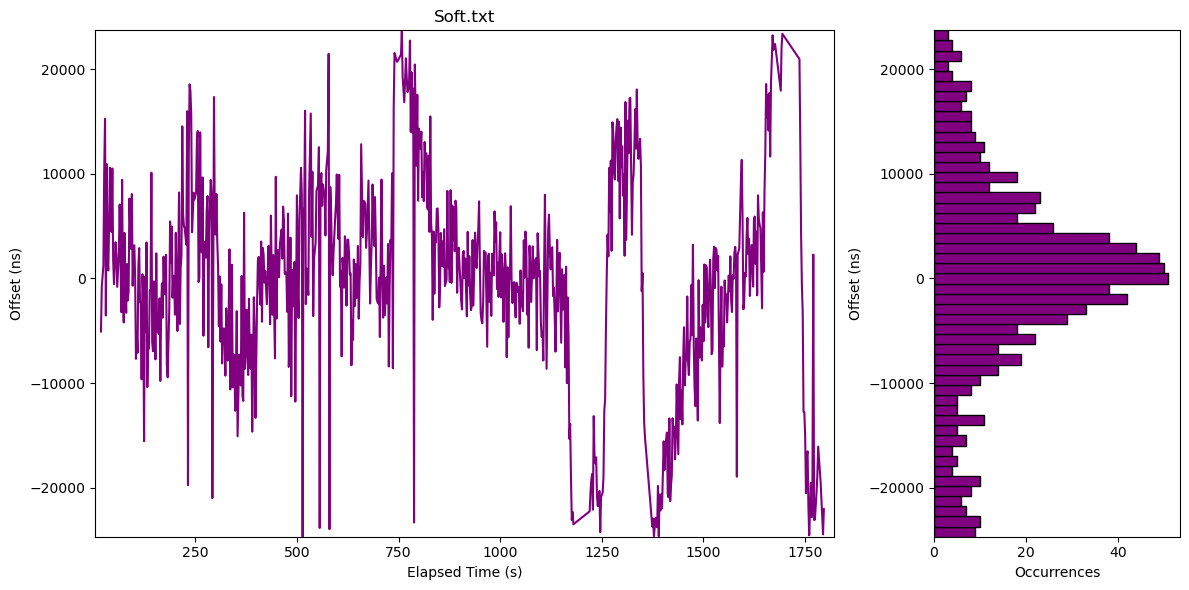

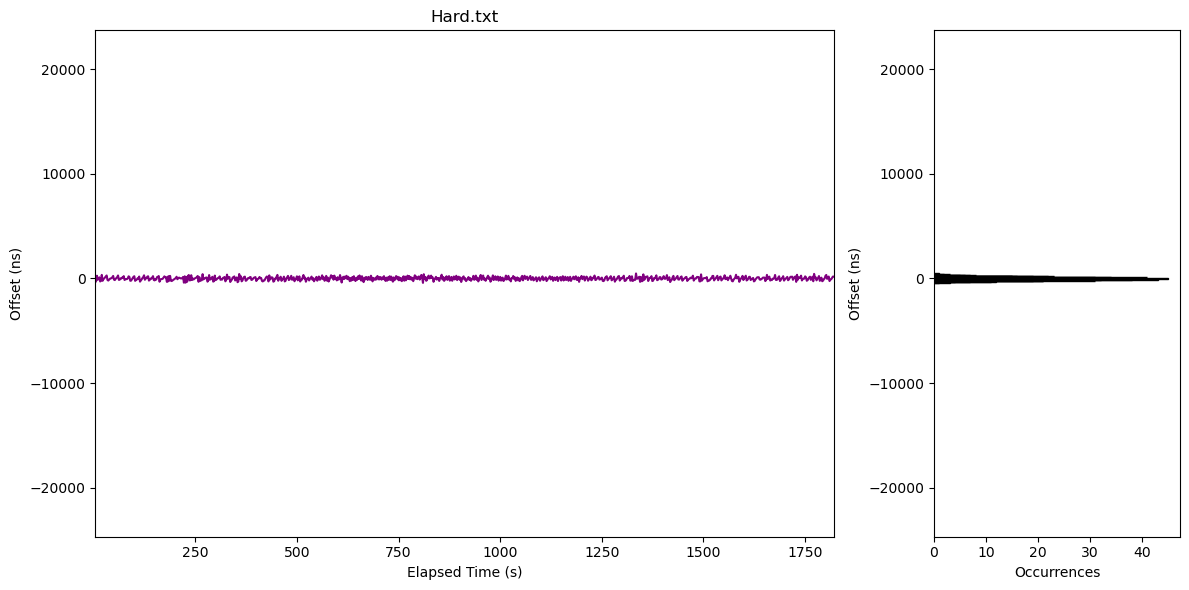

In [189]:
plot_graphs(log_files1, dataframes1, 'Offset (ns)', 'offset_results', 'purple')

### 1.5 - Análise inferencial

Visualmente ja podemos vislumbrar a superioridade de precisão do Hardware Timestamping, para confirmar essa impressão realizaremos a seguir o teste de hipótese, mas antes iremos verificar se os dados em questão seguem uma distribuição nomral para definir qual teste é adequado. 

Hardware timestamping - Shapiro-Wilk test:
Statistic: 0.9913870094394018, p-value: 3.957672420589601e-05

Software timestamping - Shapiro-Wilk test:
Statistic: 0.9732980740133639, p-value: 7.357812460784193e-11

Os dados de hardware timestamping não são normalmente distribuídos.
Os dados de software timestamping não são normalmente distribuídos.


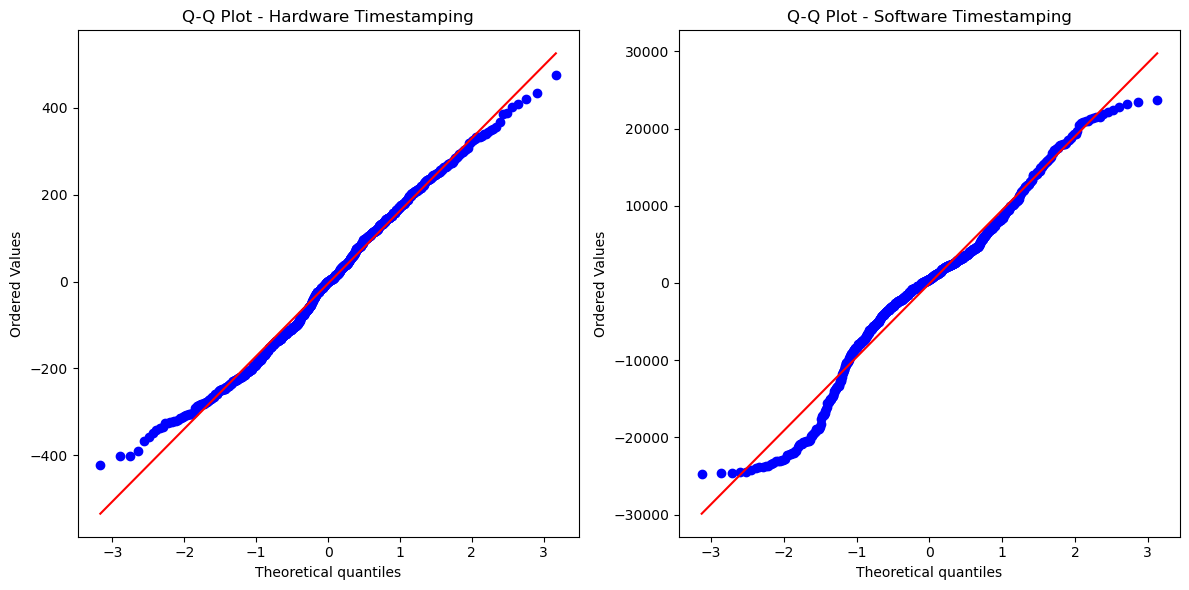

In [190]:
offsets_hardware = df_h_log['time_offset']
offsets_software = df_s_log['time_offset']

shapiro_hardware = shapiro(offsets_hardware)
shapiro_software = shapiro(offsets_software)

print("Hardware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_hardware.statistic}, p-value: {shapiro_hardware.pvalue}")

print("\nSoftware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_software.statistic}, p-value: {shapiro_software.pvalue}")

alpha = 0.05
if shapiro_hardware.pvalue < alpha:
    print("\nOs dados de hardware timestamping não são normalmente distribuídos.")
else:
    print("\nOs dados de hardware timestamping são normalmente distribuídos.")

if shapiro_software.pvalue < alpha:
    print("Os dados de software timestamping não são normalmente distribuídos.")
else:
    print("Os dados de software timestamping são normalmente distribuídos.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
probplot(offsets_hardware, dist="norm", plot=plt)
plt.title('Q-Q Plot - Hardware Timestamping')

plt.subplot(1, 2, 2)
probplot(offsets_software, dist="norm", plot=plt)
plt.title('Q-Q Plot - Software Timestamping')

plt.tight_layout()
plt.show()

Como os dados não seguem uma distribuição normal optammos por usar o teste não parametrico de _Mann-Whitney U_ com as seguintes hipóteses:

- Hipótese Nula (H0): As duas amostras vêm da mesma distribuição ou têm medianas iguais.

- Hipótese Alternativa (H1): Existe uma diferença significativa entre as duas amostras.

In [191]:
u_stat, p_value = mannwhitneyu(offsets_hardware, offsets_software, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")


U-statistic: 331130.0
P-value: 0.006705295267861376
Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.


### Conclusões

Os resultados do teste inferencial confirmaram as observações descritivas, indicando uma diferença significativa na eficácia da sincronização entre hardware e software timestamping. O hardware timestamping demonstrou ser mais eficaz e preciso.

Em aplicações onde a precisão e a estabilidade são críticas, o hardware timestamping é claramente a escolha mais adequada. No entanto, para aplicações onde o custo e a flexibilidade são mais importantes, o software timestamping pode ser uma solução viável.

### Extra

/tmp/ipykernel_61805/4006604356.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Timestamping', y='time_offset', data=df_combined, ax=axes[1], palette='Set3')


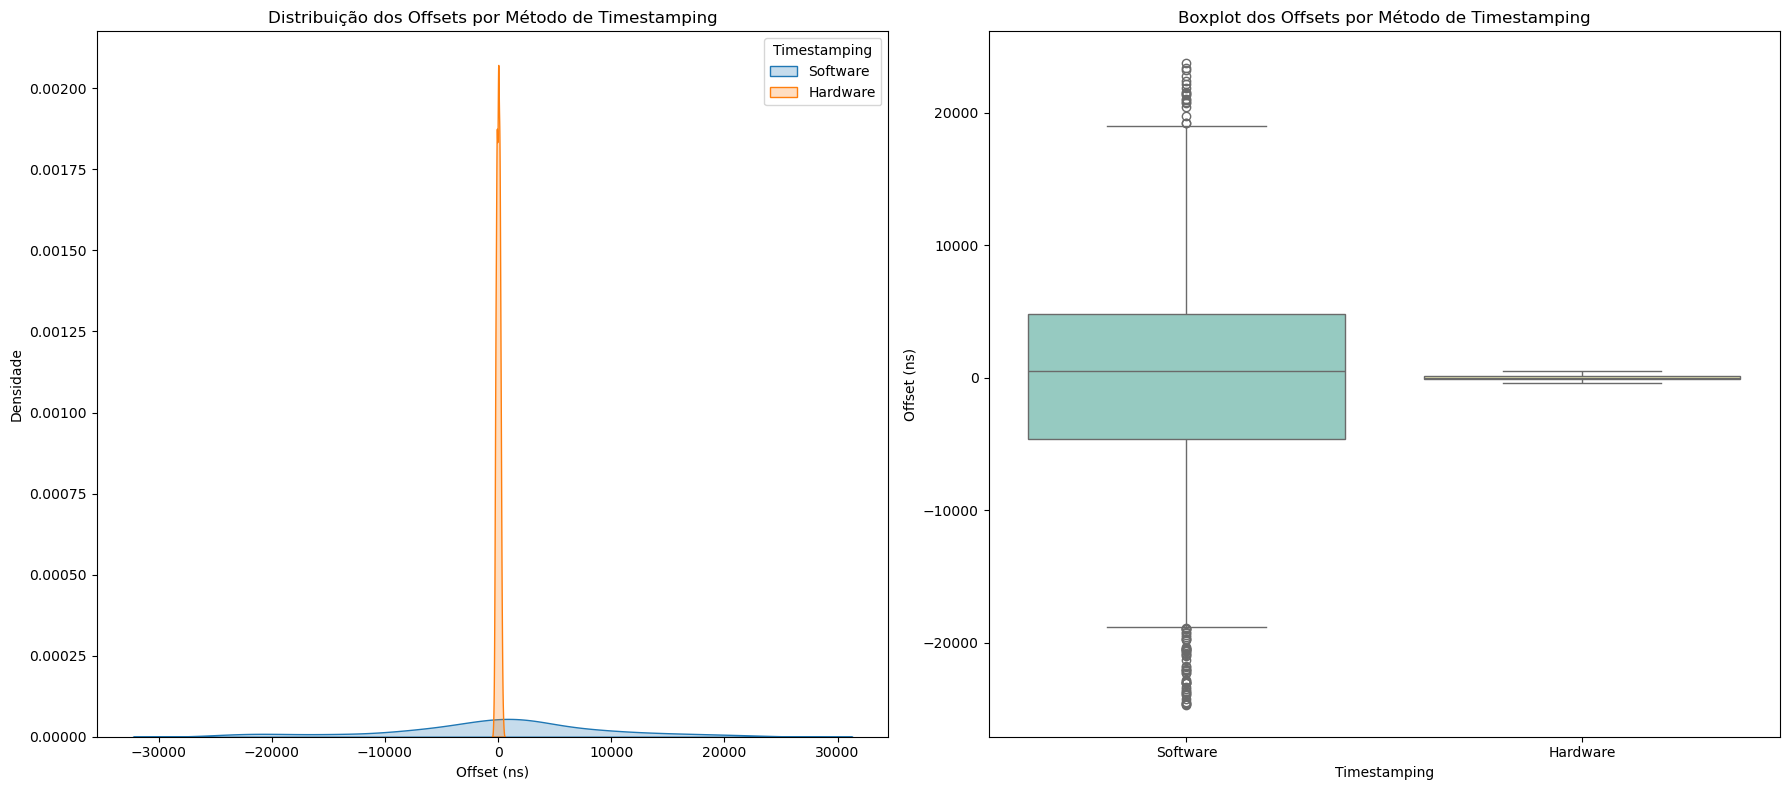

In [192]:
df_s_log['Timestamping'] = 'Software'
df_h_log['Timestamping'] = 'Hardware'

# unir DataFrames
df_combined = pd.concat([df_s_log, df_h_log])

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Densidade
for timestamping in df_combined['Timestamping'].unique():
    subset = df_combined[df_combined['Timestamping'] == timestamping]
    sns.kdeplot(subset['time_offset'], label=timestamping, fill=True, ax=axes[0])
axes[0].set_title('Distribuição dos Offsets por Método de Timestamping')
axes[0].set_xlabel('Offset (ns)')
axes[0].set_ylabel('Densidade')
axes[0].legend(title='Timestamping')

sns.boxplot(x='Timestamping', y='time_offset', data=df_combined, ax=axes[1], palette='Set3')
axes[1].set_title('Boxplot dos Offsets por Método de Timestamping')
axes[1].set_xlabel('Timestamping')
axes[1].set_ylabel('Offset (ns)')

plt.tight_layout()
plt.show()

## $II$. Topologias de Sincronização

<div style="display: flex; align-items: center;">
    <div style="margin-right: 20px;">
        <p>Para o segundo conjunto de análises vamos comparar o sincronismo em 2 configurações exploradas ao longo dessa seção. Basicamente serão utilizados os tipos de <i>relógios</i> mostrados na figura ao lado. Abaixo vemos a importação dos logs com os dados de interesse.</p>
    </div>
    <figure style="text-align: center;">
        <img src="./assets/tcbcoc.jpg" width="auto" height="auto">
        <figcaption>Fig. 6 - Diferentes tipos de <i>clock</i> PTP. <a href="https://www.cisco.com/c/en/us/td/docs/dcn/aci/apic/5x/system-management-configuration/cisco-apic-system-management-configuration-guide-51x/m-precision-time-protocol.html">Fonte</a></figcaption>
    </figure>
</div>

In [193]:
log_files2 = ['logs/TC.txt', 'logs/Switch.txt'] # Arquivos de texto contendo o log extraido do ptp4l.

# TC.txt -> Arquivo de texto contendo os logs utilizando transparent clock
# Switch.txt -> Arquivo de texto contendo os logs utilizando um switch entre os nós

dataframes2 = {}

for log_file in log_files2:
    dataframes2[log_file] = process_log_file(log_file, offset_pattern, freq_pattern)

df_TC_log = dataframes2['logs/TC.txt']
df_Switch_log = dataframes2['logs/Switch.txt']

Abaixo realizamos a remoção de outliers pelo motivo explicado na seção anterior. Como podemos ver nas ACFs, a autocorrelação nos dados não é significativa então não foi necessária a subamostragem.

<Figure size 1000x600 with 0 Axes>

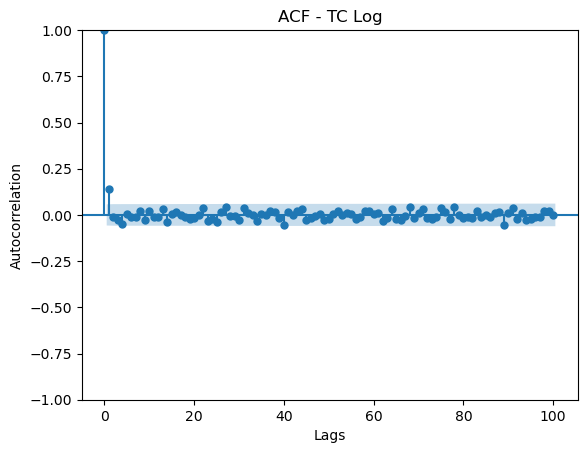

<Figure size 1000x600 with 0 Axes>

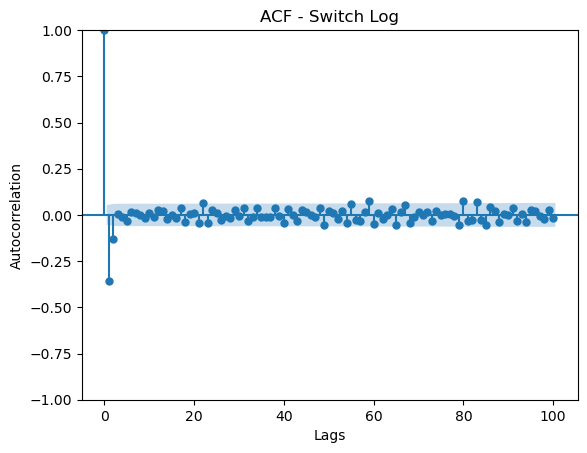

In [194]:
plot_acf_log(df_TC_log, 'time_offset', 'ACF - TC Log', lags=100) 
plot_acf_log(df_Switch_log, 'time_offset', 'ACF - Switch Log', lags=100)

In [195]:
df_TC_log = dataframes2['logs/TC.txt']
df_Switch_log = dataframes2['logs/Switch.txt']

df_TC_log = remove_outliers(df_TC_log, 'time_offset')
df_Switch_log = remove_outliers(df_Switch_log, 'time_offset')

dataframes2['logs/TC.txt'] = df_TC_log
dataframes2['logs/Switch.txt'] = df_Switch_log

### 2.1 - Topologias

Com os dados importados e filtrados podemos começar a descrição dos cenários:

#### 2.1.1 - **PC 3 (PTP _Master_) --> Switch PTP Unaware --> PC 1 (PTP _Slave_):**


A topologia mostrada na fig. 7 é uma configuração simples de sincronização PTP (Precision Time Protocol) onde um _Master_ e um _Slave_ estão conectados através de um switch Ethernet comum (PTP-unaware). O _Master_ envia mensagens de sincronização para o Slave, que ajusta seu relógio com base nelas. O switch utilizado não compensa os atrasos dos pacotes, o que pode introduzir variabilidade nos offsets e limitar a precisão da sincronização de tempo.

<div style="text-align: center;">
        <img src="./assets/topo2.png" width="640" height="480">
        <figcaption>Fig. 7 - Topologia Switch do teste 2.</figcaption>
    </figure>
</div>

In [196]:
df_Switch_log.describe()

,seconds,time_offset,frequency_offset
count,1346.000000,1346.000000,1345.000000
mean,672.873446,0.764487,-14871.982156
std,389.078035,245.829890,255.812652
min,0.000000,-644.000000,-15657.000000
25%,336.338000,-171.750000,-15050.000000
50%,672.673500,1.500000,-14873.000000
75%,1009.003000,180.750000,-14687.000000
max,1346.338000,614.000000,-14137.000000


#### 2.1.2 - **PC 3 (PTP Master) --> PC 2 (_Transparent clock_) --> PC 1 (PTP _Slave_)**

A topologia mostrada na Fig. 8 é uma configuração PTP (Precision Time Protocol) com um _Transparent clock_ (TC) entre o Master e o _Slave_. O Master envia mensagens de sincronização através do TC, que mede o tempo que os pacotes levam para atravessar o dispositivo e adiciona essa informação ao campo de correção dos pacotes. O Slave então ajusta seu relógio com base nessas informações, compensando os atrasos introduzidos pelo TC. Esta configuração melhora a precisão da sincronização ao garantir que os atrasos ao longo do caminho são contabilizados, reduzindo a variabilidade nos offsets e aumentando a estabilidade temporal da rede.

<div style="text-align: center;">
        <img src="./assets/tc.png" width="740" height="480">
        <figcaption>Fig. 8 - Topologia TC do teste 2.</figcaption>
    </figure>
</div>

In [197]:
df_TC_log.describe()

,seconds,time_offset,frequency_offset
count,1163.000000,1163.000000,1163.000000
mean,527.861494,0.028375,-3077.022356
std,303.344466,12.880828,12.775145
min,2.700000,-36.000000,-3115.000000
25%,265.978000,-9.000000,-3086.000000
50%,527.457000,0.000000,-3076.000000
75%,790.735000,8.500000,-3069.000000
max,1052.213000,35.000000,-3038.000000


### 2.2 - Comparacão

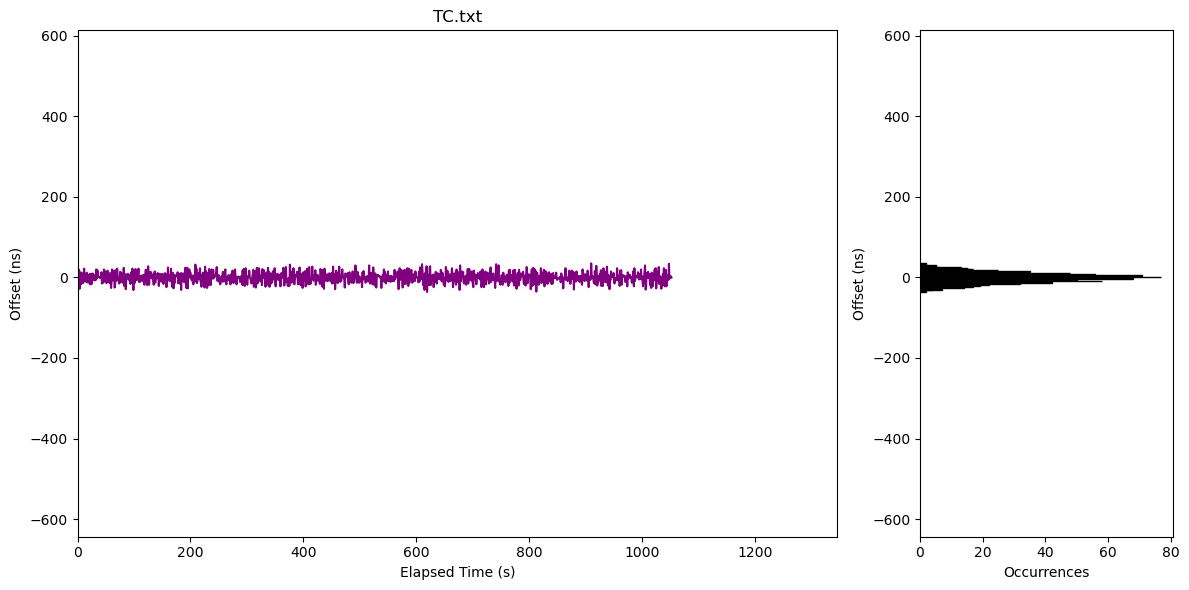

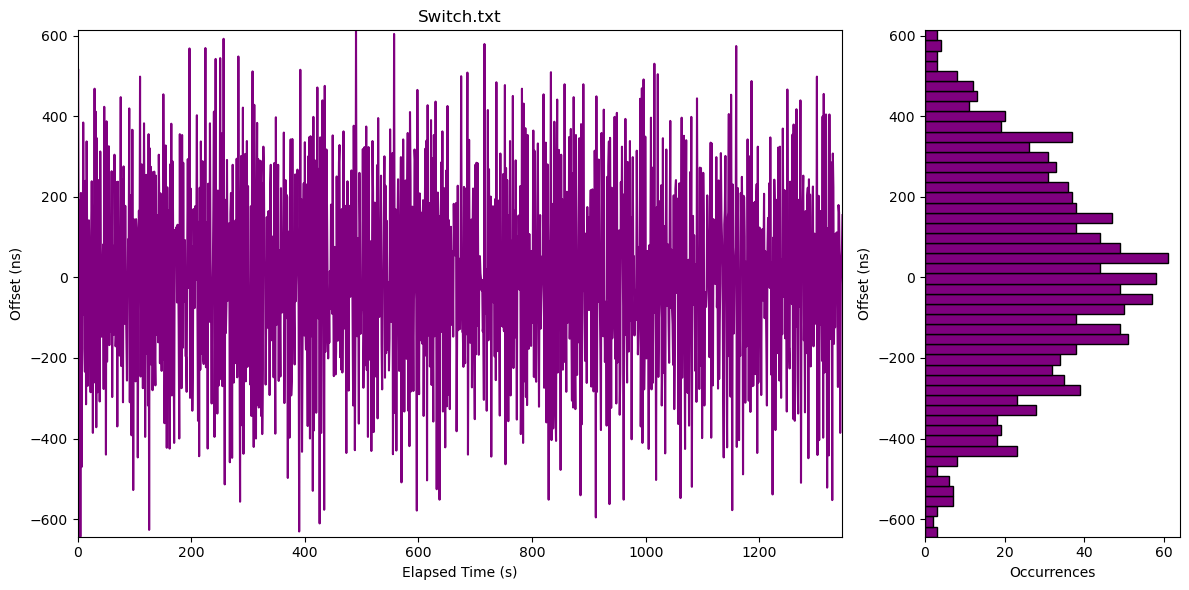

In [198]:
plot_graphs(log_files2, dataframes2, 'Offset (ns)', 'offset_results', 'purple')

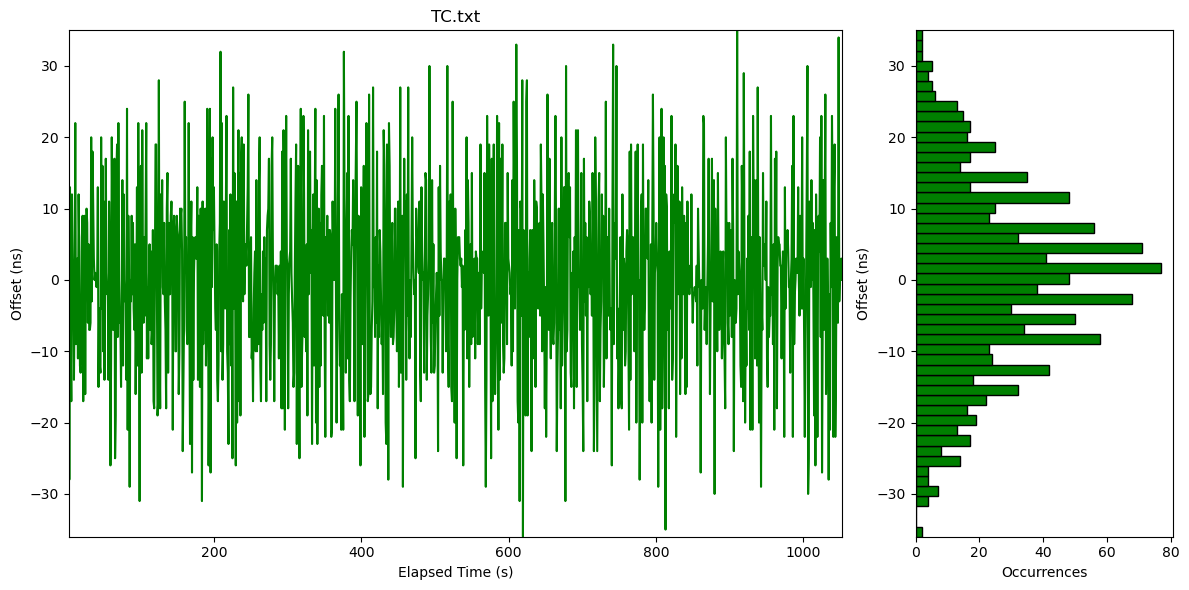

In [199]:
plot_graphs(log_files2, dataframes2, 'Offset (ns)', 'offset_results', 'green','logs/TC.txt')

### 2.3 - Análises inferenciais

Visualmente ja podemos evidenciar a superioridade de precisão da topologia com _transparent clock_, para confirmar essa impressão realizaremos a seguir o teste de hipótese, mas antes iremos verificar se os dados em questão seguem uma distribuição nomral para definir qual teste é adequado. 

TC - Shapiro-Wilk test:
Statistic: 0.9966614185118499, p-value: 0.01397306881379791

Switch - Shapiro-Wilk test:
Statistic: 0.9945015604573204, p-value: 7.386515817485482e-05

Os dados de TC não são normalmente distribuídos.
Os dados de Switch não são normalmente distribuídos.


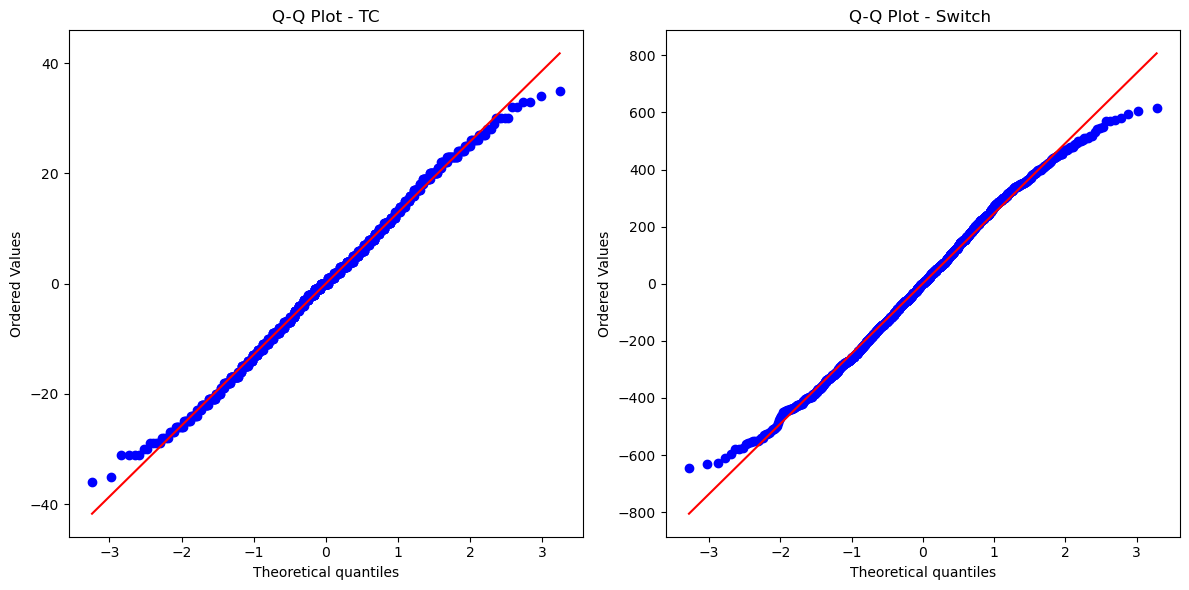

In [200]:
offset_tc = df_TC_log['time_offset']
offset_switch = df_Switch_log['time_offset']

shapiro_tc = shapiro(offset_tc)
shapiro_switch = shapiro(offset_switch)

print("TC - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_tc.statistic}, p-value: {shapiro_tc.pvalue}\n")

print("Switch - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_switch.statistic}, p-value: {shapiro_switch.pvalue}\n")

alpha = 0.05

if shapiro_tc.pvalue < alpha:
    print("Os dados de TC não são normalmente distribuídos.")
else:
    print("Os dados de TC são normalmente distribuídos.")

if shapiro_switch.pvalue < alpha:
    print("Os dados de Switch não são normalmente distribuídos.")
else:
    print("Os dados de Switch são normalmente distribuídos.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
probplot(offset_tc, dist="norm", plot=plt)
plt.title('Q-Q Plot - TC')

plt.subplot(1, 2, 2)
probplot(offset_switch, dist="norm", plot=plt)
plt.title('Q-Q Plot - Switch ')

plt.tight_layout()
plt.show()

Como os dados não seguem uma distribuição normal optammos por usar o teste não parametrico de _Mann-Whitney U_ com as seguintes hipóteses:

- Hipótese Nula (H0): As duas amostras vêm da mesma distribuição ou têm medianas iguais.

- Hipótese Alternativa (H1): Existe uma diferença significativa entre as duas amostras

In [201]:
u_stat, p_value = mannwhitneyu(offset_tc, offset_switch, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: Há uma diferença significativa na precisão da sincronização entre a topologia com Transparent Clock e a com Switch Unaware.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na precisão da sincronização entre a topologia com Transparent Clock e a com Switch Unaware.")


U-statistic: 780719.5
P-value: 0.9129080370508595
Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na precisão da sincronização entre a topologia com Transparent Clock e a com Switch Unaware.


Como vimos, os gráficos mostram uma diferença clara: o _Transparent clock_ aparenta ter uma precisão maior, com offsets mais estáveis e concentrados em torno de zero, enquanto o Switch Unaware mostra offsets dispersos e variáveis. No entanto, estatisticamente, não podemos corroborar essa afirmação. Essa inconsistência entre a análise descritiva, através dos gráficos, e a análise inferencial, através dos testes, pode ocorrer por várias razões:

- **Tamanho da Amostra:** Se o tamanho da amostra for pequeno, a estatística inferencial pode não ter poder suficiente para detectar uma diferença estatisticamente significativa, mesmo que visualmente ou descritivamente ela pareça evidente. Quanto menor a amostra, maior a variabilidade aleatória e maior o erro padrão, o que dificulta a detecção de diferenças. Uma amostra maior tende a proporcionar mais precisão aos testes inferenciais e a reduzir a discrepância entre o que vemos visualmente e o que os testes indicam.

- **Variabilidade Dentro dos Grupos:** Quando há uma alta variabilidade dentro dos grupos (por exemplo, dentro dos offsets de cada topologia), essa dispersão interna pode mascarar as diferenças entre as médias dos grupos. Nesse caso, mesmo que visualmente uma topologia pareça mais estável, a inferência estatística pode falhar em encontrar uma diferença significativa se a variabilidade interna for alta. Por isso, alguns testes assumem homocedasticidade (igualdade de variâncias).

Por essa razão, decidimos complementar a análise inferencial utilizando o teste de Levene para comparar a variabilidade das topologias. Além disso, uma topologia pode ter uma média de offset próxima a zero, como é o caso das últimas duas testadas, mas se a variação for alta, a sincronização não será precisa. Uma variância maior é indicativa de que a topologia introduz mais variabilidade (jitter) nos offsets, o que compromete a precisão da sincronização.

In [202]:
# Realizar o Teste de Levene
stat, p_value = levene(offset_tc, offset_switch)

print(f"Levene Test Statistic: {stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: As variâncias dos offsets são significativamente diferentes.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que as variâncias dos offsets são diferentes.")

Levene Test Statistic: 2096.438671196037
P-value: 0.0
Rejeitamos a hipótese nula: As variâncias dos offsets são significativamente diferentes.


### Conclusões

O __Teste de Levene__ revelou uma heterocedasticidade significativa entre os dois grupos de dados, confirmando que as variâncias dos offsets entre as topologias de Transparent Clock e Switch Unaware são substancialmente diferentes. Isso não só corrobora a análise visual, mas também aponta para importantes implicações técnicas na escolha e análise das topologias de sincronização de tempo.

Nos gráficos, a topologia com Switch Unaware apresenta uma variabilidade elevada nos offsets, o que se traduz em uma dispersão maior em torno da média, com valores de offset que flutuam amplamente entre valores positivos e negativos. Isso é evidenciado pelos altos valores de desvio padrão e pela amplitude dos valores dos offsets. Essa variabilidade interna pode ser causada por fatores como:

- **Latência Variável:** O switch unaware, diferente do transparent clock, não ajusta nem compensa os atrasos que os pacotes PTP (Precision Time Protocol) sofrem ao atravessar o dispositivo, resultando em latências inconsistentes que introduzem flutuações nos offsets.

- **Congestionamento de Rede:** A ausência de mecanismos para medir e corrigir os tempos de propagação nos switches pode fazer com que variações na carga da rede (por exemplo, congestão ou mudanças na rota dos pacotes) afetem a precisão da sincronização, aumentando a variabilidade dos offsets.

A latência variável e o congestionamento de rede têm um impacto significativo na precisão da sincronização na topologia com Switch Unaware. A topologia com Transparent Clock, por outro lado, é mais robusta a essas variabilidades, proporcionando uma sincronização mais consistente.

### Extra

/tmp/ipykernel_61805/2242320215.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Topology', y='time_offset', data=df_combined, palette='Set2', ax=axes[1])


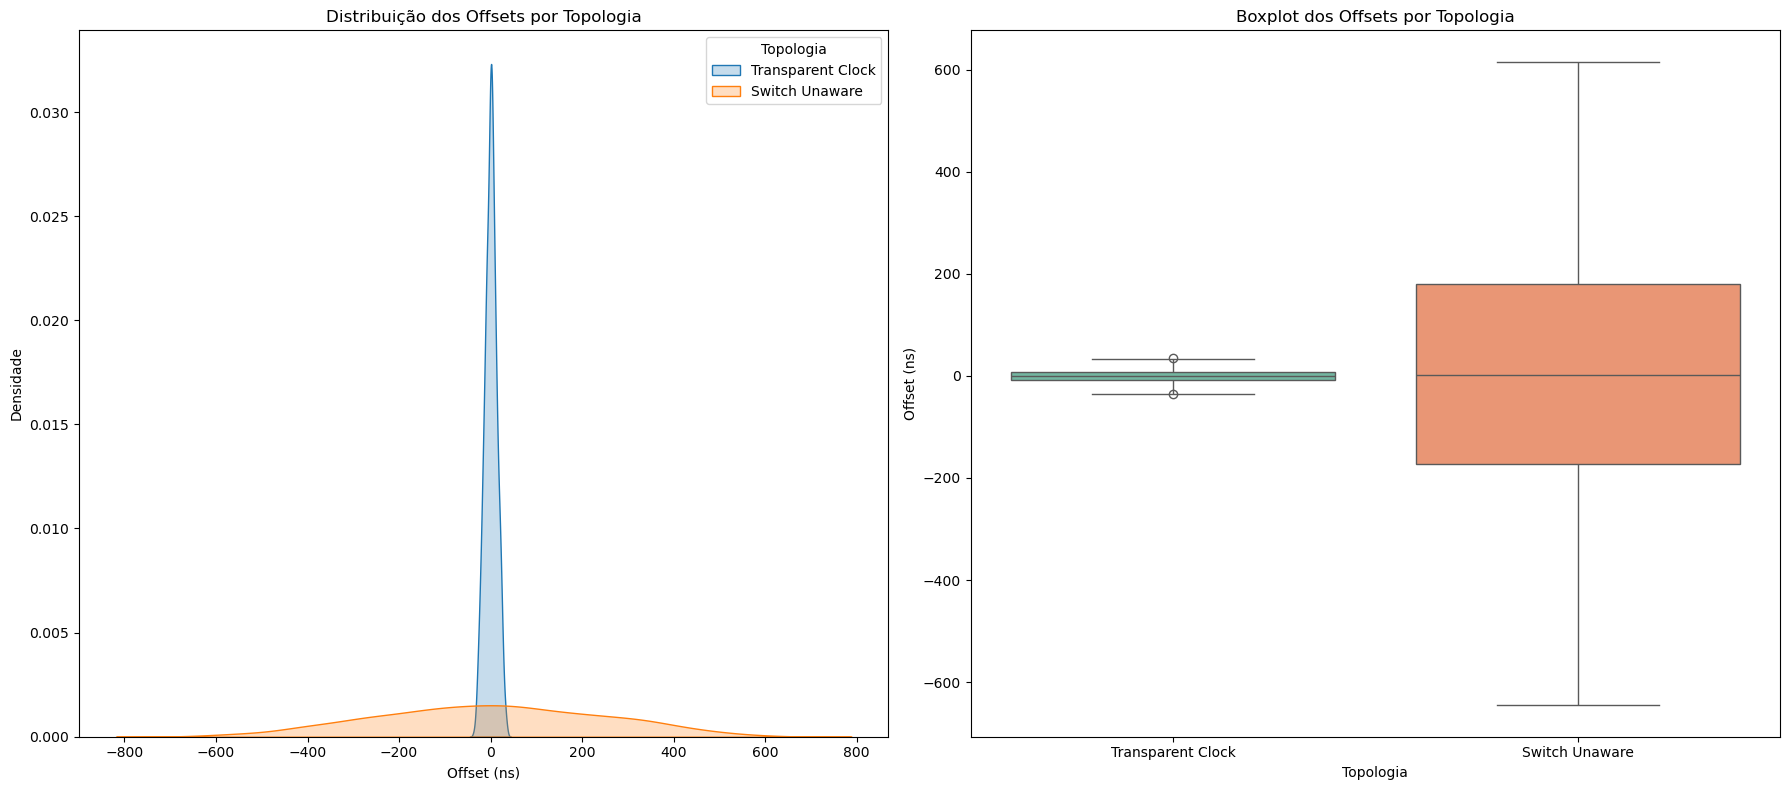

In [203]:
# coluna para identificar a topologia
df_TC_log['Topology'] = 'Transparent Clock'
df_Switch_log['Topology'] = 'Switch Unaware'

# juntar dfs
df_combined = pd.concat([df_TC_log, df_Switch_log])

# plots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Densidade
for topology in df_combined['Topology'].unique():
    subset = df_combined[df_combined['Topology'] == topology]
    sns.kdeplot(subset['time_offset'], label=topology, fill=True, ax=axes[0])
axes[0].set_title('Distribuição dos Offsets por Topologia')
axes[0].set_xlabel('Offset (ns)')
axes[0].set_ylabel('Densidade')
axes[0].legend(title='Topologia')

# Boxplot
sns.boxplot(x='Topology', y='time_offset', data=df_combined, palette='Set2', ax=axes[1])
axes[1].set_title('Boxplot dos Offsets por Topologia')
axes[1].set_xlabel('Topologia')
axes[1].set_ylabel('Offset (ns)')

plt.tight_layout()
plt.show()

### Referências

LinuxPTP. (n.d.). Retrieved from https://linuxptp.sourceforge.net/

EndRun Technologies. (n.d.). Precision Time Protocol (PTP). Retrieved from https://endruntechnologies.com/pdf/PTP-1588.pdf

Cisco Systems. (n.d.). Cisco PTP Guide. Retrieved from https://www.cisco.com/c/en/us/td/docs/dcn/aci/apic/5x/system-management-configuration/cisco-apic-system-management-configuration-guide-51x/m-precision-time-protocol.html

Rouwet, W. (2022). Synchronization in open radio access networks. In W. Rouwet (Ed.), Open Radio Access Network (O-RAN) Systems Architecture and Design (pp. 265-307). Academic Press. https://doi.org/10.1016/B978-0-323-91923-4.00005-7

Cochran, R., Marinescu, C., & Riesch, C. (2011). Synchronizing the linux system time to a ptp hardware clock. In 2011 IEEE International Symposium on Precision Clock Synchronization for Measurement, Control and Communication (pp. 87–92). IEEE. https://doi.org/10.1109/ISPCS.2011.6070148